# Using the `Network` object

Let's read in a sample MATSim network into GeNet's `Network` object.

In [1]:
from genet import Network
import os

n = Network('epsg:27700')
path_to_matsim_network = '../example_data/pt2matsim_network'
n.read_matsim_network(os.path.join(path_to_matsim_network, 'network.xml'))
n.read_matsim_schedule(os.path.join(path_to_matsim_network, 'schedule.xml'))
n.print()

Graph info: Name: Network graph
Type: MultiDiGraph
Number of nodes: 1662
Number of edges: 3166
Average in degree:   1.9049
Average out degree:   1.9049 
Schedule info: Schedule:
Number of services: 9
Number of unique routes: 68
Number of stops: 45


## Summary

The data saved on the edges or nodes of the graph can be nested. There are a couple of convenient methods that summarise the schema of the data found on the nodes and links. If `data=True`, the output also shows up to 5 unique values stored in that location.

In [2]:
n.node_attribute_summary(data=True)

attribute
├── id: ['1204707018', '255562', '281454961', '294158436', '25500758']
├── x: [528387.4250512555, 528391.4406755936, 528393.2742107178, 528396.6287644263, 528396.3513181042]
├── y: [181547.5850354673, 181552.72935927223, 181558.10532352765, 181559.970402835, 181562.0370527053]
├── lon: [-0.15178558709839862, -0.15872448710537235, -0.13569068709168342, -0.13766218709633904, -0.13543658708819173]
├── lat: [51.51609983324067, 51.5182034332405, 51.51504733324089, 51.522253033239515, 51.522948433239556]
└── s2_id: [5221390710015643649, 5221390314367946753, 5221366508477440003, 5221390682291777543, 5221390739236081673]


In [3]:
n.link_attribute_summary(data=False)

attribute
├── id
├── from
├── to
├── freespeed
├── capacity
├── permlanes
├── oneway
├── modes
├── s2_from
├── s2_to
├── attributes
│   ├── osm:way:access
│   │   ├── name
│   │   ├── class
│   │   └── text
│   ├── osm:way:highway
│   │   ├── name
│   │   ├── class
│   │   └── text
│   ├── osm:way:id
│   │   ├── name
│   │   ├── class
│   │   └── text
│   ├── osm:way:name
│   │   ├── name
│   │   ├── class
│   │   └── text
│   ├── osm:relation:route
│   │   ├── name
│   │   ├── class
│   │   └── text
│   ├── osm:way:lanes
│   │   ├── name
│   │   ├── class
│   │   └── text
│   ├── osm:way:oneway
│   │   ├── name
│   │   ├── class
│   │   └── text
│   ├── osm:way:tunnel
│   │   ├── name
│   │   ├── class
│   │   └── text
│   ├── osm:way:psv
│   │   ├── name
│   │   ├── class
│   │   └── text
│   ├── osm:way:vehicle
│   │   ├── name
│   │   ├── class
│   │   └── text
│   ├── osm:way:traffic_calming
│   │   ├── name
│   │   ├── class
│   │   └── text
│   ├── osm:way:junction
│   │   ├── n

Once you see the general schema for the data stored on nodes and links, you may decide to look at or perform analysis 
on all of the data stored in the netowrk under a particular key. A GeNet network has two methods which generate a
`pandas.Series` object, which stores the nodes or links data present at the specified key, indexed by the same index 
as the nodes or links.

In [4]:
s2_id = n.node_attribute_data_under_key('s2_id')

In [5]:
s2_id

101982       5221390329378179879
101986       5221390328605860387
101990       5221390304444511271
101991       5221390303978897267
101992       5221390304897644929
                    ...         
983839058    5221390693831817171
99936        5221390297975475113
99937        5221390299484831045
99940        5221390294354743413
99943        5221390298004852605
Length: 1662, dtype: int64

In [6]:
n.link_attribute_data_under_key('freespeed').head()

1       4.166667
10      4.166667
100     4.166667
1000    4.166667
1001    4.166667
dtype: float64

Or you can access nested data,

In [7]:
n.link_attribute_data_under_key({'attributes': {'osm:way:lanes': 'text'}}).head()

1007    2
1008    2
1037    2
1038    2
1039    2
dtype: object

You can also build a `pandas.DataFrame` out of several keys.

In [8]:
n.link_attribute_data_under_keys(['freespeed', {'attributes': {'osm:way:highway': 'text'}}]).head()

,freespeed,attributes::osm:way:highway::text
1,4.166667,unclassified
10,4.166667,unclassified
100,4.166667,unclassified
1000,4.166667,residential
1001,4.166667,residential


### Extracting links of interest

The function below gathers link ids which satisfy conditions 
to arbitrary level of nested-ness. It also allows quite flexible conditions---below we require that the link value
at `data['attributes']['osm:way:highway']['text'] == 'primary'`, where data is the data dictionary stored on that link.

In [9]:
from genet import graph_operations

In [10]:
links = graph_operations.extract_links_on_edge_attributes(
    n,
    conditions= {'attributes': {'osm:way:highway': {'text': 'primary'}}},
)

In [11]:
links[:5]

['1007', '1008', '1023', '1024', '103']

In [12]:
len(links)

619

Below we now require that the link value
at `data['attributes']['osm:way:highway']['text'] in ['primary', 'something else']`. There is nothing in the data that has such tags, so the output is the same.

In [13]:
links = graph_operations.extract_links_on_edge_attributes(
    n,
    conditions= {'attributes': {'osm:way:highway': {'text': ['primary', 'something else']}}},
)

In [14]:
links[:5]

['1007', '1008', '1023', '1024', '103']

In [15]:
len(links)

619

We can also pass a list of conditions. In this case it makes sense for us to specify how multiple conditions should be handled. We can do it via 
- `how=all` - all conditions need to be met
- `how=any` - at least one condition needs to be met

It is set to `any` as default.

In [16]:
links = graph_operations.extract_links_on_edge_attributes(
    n,
    conditions= [{'attributes': {'osm:way:highway': {'text': 'primary'}}},
                 {'attributes': {'osm:way:highway': {'text': 'something else'}}}],
    how=any
)

In [17]:
links[:5]

['1007', '1008', '1023', '1024', '103']

In [18]:
len(links)

619

In [19]:
links = graph_operations.extract_links_on_edge_attributes(
    n,
    conditions= [{'attributes': {'osm:way:highway': {'text': 'primary'}}},
                 {'attributes': {'osm:way:highway': {'text': 'something else'}}}],
    how=all
)

In [20]:
links[:5]

[]

As expected, no links satisfy both `data['attributes']['osm:way:highway']['text'] == 'primary'` and `data['attributes']['osm:way:highway']['text'] == 'something else'`.

Below, we give an example of subsetting a numeric boundary. We find links where `0 <= 'freespeed'  <= 20`.

In [21]:
links = graph_operations.extract_links_on_edge_attributes(
    n,
    conditions = {'freespeed': (0,20)},
)

In [22]:
links[:5]

['1', '10', '100', '1000', '1001']

In [23]:
len(links)

2334

Finally, we can define a function that will handle the condition for us. The function should take the value expected at the key in the data dictionary and return either `True` or `False`.

For example, below we give an example equivalent to our first example of `data['attributes']['osm:way:highway']['text'] == 'primary'` but using a function we defined ourselves to handle the condition.

In [24]:
def highway_primary(value):
    return value == 'primary'

links = graph_operations.extract_links_on_edge_attributes(
    n,
    conditions= {'attributes': {'osm:way:highway': {'text': highway_primary}}},
)

In [25]:
links[:5]

['1007', '1008', '1023', '1024', '103']

In [26]:
len(links)

619

This allows for really flexible subsetting of the network based on data stored on the edges. Another example, similar to the numeric boundary, but this time we only care about the upper bound and we make it a strict inequality.

In [27]:
def below_20(value):
    return value < 20

links = graph_operations.extract_links_on_edge_attributes(
    n,
    conditions= {'freespeed': below_20},
)

In [28]:
links[:5]

['1', '10', '100', '1000', '1001']

In [29]:
len(links)

2334

## Using the `Schedule` object

In [30]:
n.schedule.print()

Schedule:
Number of services: 9
Number of unique routes: 68
Number of stops: 45


You can plot the `Schedule` object. It will result in plotting the ocnnections between stops for all `Route`s within all `Service`s. To plot the network routes of the `Schedule` you need information about the `Network`, this can be done using the `plot` function for the `Network` object.

/Users/kasia.kozlowska/pycharm_venvs/genet/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/kasia.kozlowska/pycharm_venvs/genet/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


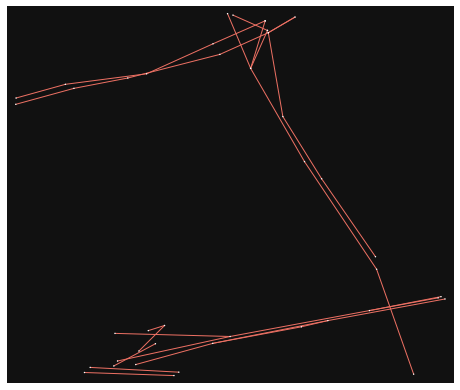

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11dbc3400>)

In [31]:
n.schedule.plot()

In [32]:
n.schedule.service_ids()[:5]

['12430', '14073', '14134', '15234', '15660']

In [33]:
service = n.schedule['12430']
service.print()

Service ID: 12430
Name: 205
Number of routes: 12
Number of unique stops: 11


/Users/kasia.kozlowska/pycharm_venvs/genet/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


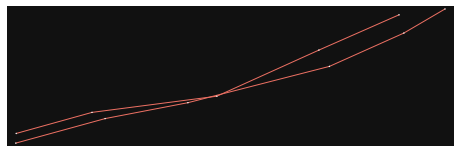

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11dbe45b0>)

In [34]:
service.plot()

In [35]:
route = n.schedule.route('VJ948e8caa0f08b9c6bf6330927893942c474b5100')
route.print()

Route ID: VJ948e8caa0f08b9c6bf6330927893942c474b5100
Name: 205
Number of stops: 5
Number of trips: 10


/Users/kasia.kozlowska/pycharm_venvs/genet/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


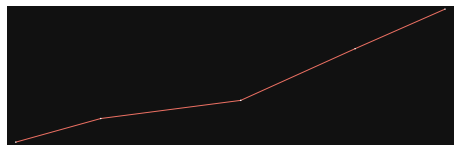

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11dbddd00>)

In [36]:
route.plot()

In [37]:
stop = n.schedule.stop('490007807E.link:1154')
stop.print()

Stop ID: 490007807E.link:1154
Projection: epsg:27700
Lat, Lon: 51.52336503, -0.14951799
linkRefId: 1154
